In [1]:
'''
Plot modeled sea ice variables forecasts
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt, mpld3
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

import esio
import esiodata as ed

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
# Define model
model='yopp'
runType='forecast'

In [3]:
#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()
# Directories
model_label = E.model[model]['model_label']
model_grid_file = E.model[model]['grid']
stero_grid_file = E.obs['NSIDC_0051']['grid']

fig_dir = os.path.join(E.fig_dir, 'model', model, 'standard')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
# Load in Model
model_forecast = os.path.join(E.model[model][runType]['sipn_nc'], '*.nc')
ds_model = xr.open_mfdataset(model_forecast)
ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

#############################################################

In [4]:
# Get regional averages
mod_reg = esio.agg_by_domain(da_grid=ds_model.sic, ds_region=ds_region)

In [5]:
# Aggregate over entire domain
mod_avg = (ds_model.sic * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)

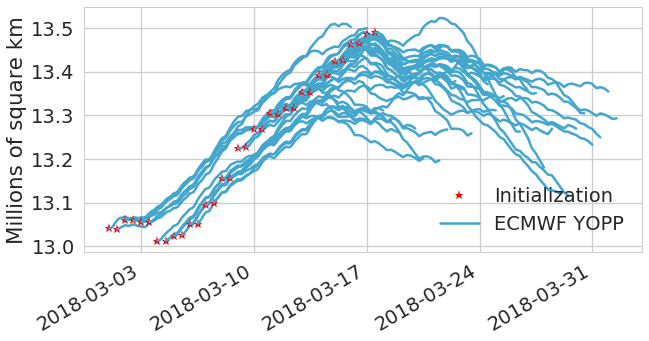

In [6]:
# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
esio.plot_reforecast(ds=mod_avg, axin=ax1, labelin=model_label, color='cycle_ensemble', marker=None)
ax1.set_ylabel('Millions of square km')
plt.legend(loc='lower right') #bbox_to_anchor=(1.03, 1.05)
f.autofmt_xdate()
f.savefig(os.path.join(fig_dir,'panArcticSIC_LongRange_'+model+'_'+runType+'.png'),bbox_inches='tight',dpi=200)
mpld3.save_html(f, os.path.join(fig_dir,'panArcticSIC_LongRange_'+model+'_'+runType+'.html'))

Sea of Okhotsk   
Bering           
Hudson Bay       
St John          
Baffin Bay       
East Greeland Sea
Barents Sea      
Kara Sea         
Laptev Sea       
East Siberian Sea
Chukchi Sea      
Beaufort Sea     
Canadian Islands 
Central Arctic   


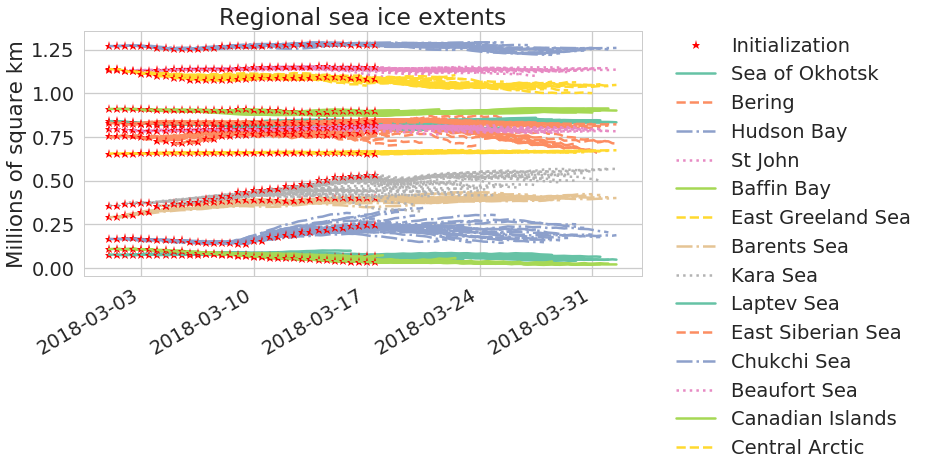

In [7]:
# Plot regional sea ice extents
cmap_reg = itertools.cycle(sns.color_palette("Set2", mod_reg.nregions.size))
linecycler = itertools.cycle(["-","--","-.",":"])
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)
for cd in mod_reg.nregions:
    print(cd.region_names.values)
    esio.plot_reforecast(ds= mod_reg.sel(nregions=cd), 
                         linestyle=next(linecycler),
                         color=next(cmap_reg),
                         axin=ax1, 
                         labelin=mod_reg.region_names.sel(nregions=cd).values,
                         marker=None)
ax1.set_title('Regional sea ice extents')
ax1.set_ylabel('Millions of square km')
# plt.legend(bbox_to_anchor=(1.03, 1.05))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.03, 1.05))
f.autofmt_xdate()
f.savefig(os.path.join(fig_dir,'panArcticSIC_LongRange_Regional_'+model+'_'+runType+'.png'),bbox_inches='tight',dpi=200)
mpld3.save_html(f, os.path.join(fig_dir,'panArcticSIC_LongRange_Regional_'+model+'_'+runType+'.html'))

In [8]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'green')

In [9]:
# Plot sea ice concentration MAPS 
# Most recent initialization time
# From ensemble mean (if ensemble availble)
# ALL forecast times

c_da = ds_model.sic.isel(init_time=ds_model.init_time.size-1).mean(dim='ensemble')
  
for (k, FT) in enumerate(ds_model.fore_time):
    
    (f, ax1) = esio.polar_axis()
    f.set_size_inches(10, 5)
    
    init_time =  pd.to_datetime( c_da.init_time.values).strftime('%Y-%m-%d-%H:%M')
    valid_time = pd.to_datetime( c_da.init_time.values + c_da.sel(fore_time=FT).fore_time.values ).strftime('%Y-%m-%d-%H:%M')

    c_da.sel(fore_time=FT).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                         transform=ccrs.PlateCarree(),
                                         cmap=cmap_sic,
                          vmin=0, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    ax1.set_title(model+'\n Initialization Time: '+init_time+'\n Valid Time: '+valid_time)
    plt.tight_layout()
    f.savefig(os.path.join(fig_dir,'panArctic_SIC_EnsembleMean_'+model+'_'+ runType+'_'+init_time+'_'+valid_time+'.png'),bbox_inches='tight',dpi=200)
    plt.close(f)